In [2]:
import pandas as pd  # Veri işleme
import numpy as np  # Sayısal işlemler
import matplotlib.pyplot as plt  # Veri görselleştirme
import seaborn as sns  # İstatistiksel veri görselleştirme
import gc

In [3]:
games = pd.read_csv('games.csv')
recommendations = pd.read_csv('recommendations.csv')
users = pd.read_csv('users.csv')

In [4]:
print("games.csv başlıkları:", list(games.columns))

games.csv başlıkları: ['app_id', 'title', 'date_release', 'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_final', 'price_original', 'discount', 'steam_deck']


In [5]:
print("recommendations.csv başlıkları:", list(recommendations.columns))

recommendations.csv başlıkları: ['app_id', 'helpful', 'funny', 'date', 'is_recommended', 'hours', 'user_id', 'review_id']


In [6]:
print("users.csv başlıkları:", list(users.columns))

users.csv başlıkları: ['user_id', 'products', 'reviews']


In [7]:
print("games.csv veri tipleri:\n", games.dtypes)

games.csv veri tipleri:
 app_id              int64
title              object
date_release       object
win                  bool
mac                  bool
linux                bool
rating             object
positive_ratio      int64
user_reviews        int64
price_final       float64
price_original    float64
discount          float64
steam_deck           bool
dtype: object


In [8]:
print("\nrecommendations.csv veri tipleri:\n", recommendations.dtypes)


recommendations.csv veri tipleri:
 app_id              int64
helpful             int64
funny               int64
date               object
is_recommended       bool
hours             float64
user_id             int64
review_id           int64
dtype: object


In [9]:
print("\nusers.csv veri tipleri:\n", users.dtypes)


users.csv veri tipleri:
 user_id     int64
products    int64
reviews     int64
dtype: object


In [10]:
# recommendations.csv'deki date sütununu datetime formatına çevir
recommendations['date'] = pd.to_datetime(recommendations['date'], errors='coerce')

In [11]:
# date sütunundaki hatalı dönüşümleri kontrol et (NaT olanlar)
print("Date sütununda hatalı dönüşüm (NaT) sayısı:", recommendations['date'].isnull().sum())

Date sütununda hatalı dönüşüm (NaT) sayısı: 0


In [12]:
# 1 inceleme yazan kullanıcıları belirleme
single_review_users = users[users['reviews'] == 1]['user_id']

# Bu kullanıcıları recommendations veri setinden çıkarma
filtered_recommendations = recommendations[~recommendations['user_id'].isin(single_review_users)]

# Sonuçları kontrol etme
print(f"Orijinal recommendations veri setindeki satır sayısı: {len(recommendations)}")
print(f"Filtrelenmiş recommendations veri setindeki satır sayısı: {len(filtered_recommendations)}")
print(f"Çıkarılan kullanıcı sayısı: {len(single_review_users)}")

Orijinal recommendations veri setindeki satır sayısı: 41154794
Filtrelenmiş recommendations veri setindeki satır sayısı: 33581767
Çıkarılan kullanıcı sayısı: 7573027


In [13]:
# 1. games veri setinden kriterlere uygun oyunları tespit et
excluded_games = games[
    (games['price_original'] > 20) |       # 20 dolardan pahalı oyunlar
    (games['positive_ratio'] < 75) |      # positive_ratio 75'ten düşük olan oyunlar
    (pd.to_datetime(games['date_release']).dt.year < 2000)  # 2000 yılından önce çıkan oyunlar
]

# Tespit edilen oyunların app_id'lerini al
excluded_app_ids = excluded_games['app_id']

# 2. Bu app_id'leri filtered_recommendations veri setinden çıkar
filtered_recommendations = filtered_recommendations[
    ~filtered_recommendations['app_id'].isin(excluded_app_ids)
]

# Sonuçları kontrol et
print(f"Orijinal filtered_recommendations satır sayısı: {len(recommendations)}")
print(f"Yeni filtered_recommendations satır sayısı: {len(filtered_recommendations)}")
print(f"Çıkarılan oyun sayısı: {len(excluded_app_ids)}")

Orijinal filtered_recommendations satır sayısı: 41154794
Yeni filtered_recommendations satır sayısı: 26491077
Çıkarılan oyun sayısı: 20614


In [14]:
# games veri setinde user_reviews sütununu kullanarak inceleme sayısı 50'den düşük olan oyunları bul
low_review_games = games[games['user_reviews'] < 100]

# Bu oyunların app_id'lerini al
low_review_app_ids = low_review_games['app_id']

# filtered_recommendations veri setinden bu app_id'leri çıkar
filtered_recommendations = filtered_recommendations[
    ~filtered_recommendations['app_id'].isin(low_review_app_ids)
]

print(f"50'den az inceleme yapılan oyunlar çıkarıldı.")
print(f"Kalan satır sayısı: {len(filtered_recommendations)}")

50'den az inceleme yapılan oyunlar çıkarıldı.
Kalan satır sayısı: 26212857


In [15]:
# users veri setinden 2 inceleme yapmış kullanıcıları bul
two_review_users = users[users['reviews'] == 2]

# Bu kullanıcıların user_id'lerini al
two_review_user_ids = two_review_users['user_id']

# filtered_recommendations veri setinden bu user_id'leri çıkar
filtered_recommendations = filtered_recommendations[
    ~filtered_recommendations['user_id'].isin(two_review_user_ids)
]

print(f"2 inceleme yapmış kullanıcılar çıkarıldı.")
print(f"Kalan satır sayısı: {len(filtered_recommendations)}")

2 inceleme yapmış kullanıcılar çıkarıldı.
Kalan satır sayısı: 22296064


In [16]:
# games veri setinde price_original sütununu kullanarak 3 dolardan ucuz oyunları bul
cheap_games = games[games['price_original'] < 3]

# Bu oyunların app_id'lerini al
cheap_game_app_ids = cheap_games['app_id']

# filtered_recommendations veri setinden bu app_id'leri çıkar
filtered_recommendations = filtered_recommendations[
    ~filtered_recommendations['app_id'].isin(cheap_game_app_ids)
]

# Sonuçları kontrol et
print(f"3 dolardan ucuz oyunlar çıkarıldı.")
print(f"Kalan satır sayısı: {len(filtered_recommendations)}")

3 dolardan ucuz oyunlar çıkarıldı.
Kalan satır sayısı: 7356932


In [17]:
# 1. Recommendations'da kalan kullanıcı ve oyun ID'lerini al
valid_user_ids = filtered_recommendations['user_id'].unique()
valid_game_ids = filtered_recommendations['app_id'].unique()

# 2. Games veri setini temizle (sadece valid_game_ids'deki oyunlar kalsın)
cleaned_games = games[games['app_id'].isin(valid_game_ids)]
print(f"Temizlenmiş Games Veri Seti Boyutu: {cleaned_games.shape}")

# 3. Users veri setini temizle (sadece valid_user_ids'deki kullanıcılar kalsın)
cleaned_users = users[users['user_id'].isin(valid_user_ids)]
print(f"Temizlenmiş Users Veri Seti Boyutu: {cleaned_users.shape}")

Temizlenmiş Games Veri Seti Boyutu: (6228, 13)
Temizlenmiş Users Veri Seti Boyutu: (2368365, 3)


In [18]:
# 1. Recommendations ve Users'ı user_id üzerinden birleştir
merged_users_recommendations = pd.merge(
    filtered_recommendations,
    cleaned_users,
    on='user_id',
    how='inner'
)

# 2. Yukarıdaki veri setini Games ile app_id üzerinden birleştir
merged_dataset = pd.merge(
    merged_users_recommendations,
    cleaned_games,
    on='app_id',
    how='inner'
)

# 3. Birleştirilmiş veri setinin boyutunu ve örnek bir kısmını görüntüle
print(f"Birleştirilmiş Veri Seti Boyutu: {merged_dataset.shape}")
print(merged_dataset.head())

Birleştirilmiş Veri Seti Boyutu: (7356932, 22)
    app_id  helpful  funny       date  is_recommended  hours   user_id  \
0  1766740        0      0 2022-12-18            True   12.7   6766810   
1  1766740        7      0 2022-12-26           False    2.8   7984323   
2  1766740        0      0 2022-12-13           False    3.7  13376299   
3  1766740        0      0 2022-12-10            True    2.9   5668417   
4  1766740        0      0 2022-12-09            True    3.1   5737183   

   review_id  products  reviews  ...   win    mac  linux         rating  \
0       2090       199       25  ...  True  False  False  Very Positive   
1       4283       181        7  ...  True  False  False  Very Positive   
2       6864        23        4  ...  True  False  False  Very Positive   
3       8615        58        5  ...  True  False  False  Very Positive   
4       8803       642        9  ...  True  False  False  Very Positive   

   positive_ratio user_reviews  price_final  price_origin

In [19]:
# Gereksiz sütunları kaldır
columns_to_drop = ['funny', 'helpful', 'win', 'mac', 'linux', 'price_final', 'discount', 'steam_deck']
merged_dataset = merged_dataset.drop(columns=columns_to_drop, axis=1)

# Güncel veri setinin boyutunu ve sütunlarını kontrol edin
print(f"Güncel Veri Seti Boyutu: {merged_dataset.shape}")
print(f"Kalan Sütunlar: {list(merged_dataset.columns)}")

Güncel Veri Seti Boyutu: (7356932, 14)
Kalan Sütunlar: ['app_id', 'date', 'is_recommended', 'hours', 'user_id', 'review_id', 'products', 'reviews', 'title', 'date_release', 'rating', 'positive_ratio', 'user_reviews', 'price_original']


In [20]:
# Eksik veri kontrolü
missing_data = merged_dataset.isnull().sum()

# Eksik veri içeren sütunları yazdır
print("Eksik Veriler:")
print(missing_data[missing_data > 0])

Eksik Veriler:
Series([], dtype: int64)


In [21]:
# merged_dataset'i kopyala
merged_dataset_copy = merged_dataset.copy()

In [22]:
merged_dataset_copy['user_id'] = merged_dataset_copy['user_id'].astype('int32')
merged_dataset_copy['app_id'] = merged_dataset_copy['app_id'].astype('int32')
merged_dataset_copy['hours'] = merged_dataset_copy['hours'].astype('float32')

In [23]:
# En aktif kullanıcıları ve en çok oynanan oyunları seç
top_users = merged_dataset_copy['user_id'].value_counts().nlargest(100000).index
top_games = merged_dataset_copy['app_id'].value_counts().nlargest(10000).index

# Veri setini filtrele
reduced_dataset = merged_dataset_copy[
    (merged_dataset_copy['user_id'].isin(top_users)) &
    (merged_dataset_copy['app_id'].isin(top_games))
]

# Pivot işlemini uygula
user_game_matrix = reduced_dataset.pivot_table(
    index='user_id',
    columns='app_id',
    values='hours',
    aggfunc='sum'
).fillna(0)

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
import random

# 1. İşbirlikçi Filtreleme: Kullanıcı benzerlik matrisini oluştur
user_similarity = cosine_similarity(user_game_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_game_matrix.index, columns=user_game_matrix.index)

# 2. İçerik Tabanlı Filtreleme: Oyun benzerlik matrisini oluştur
game_features = cleaned_games[['positive_ratio', 'price_original']].values
game_similarity = cosine_similarity(game_features)
game_similarity_df = pd.DataFrame(game_similarity, index=cleaned_games['app_id'], columns=cleaned_games['app_id'])

# 3. Rastgele kullanıcı seçimi
random_users = random.sample(list(user_game_matrix.index), 5)

# Kullanıcı önerilerini saklamak için bir sözlük tanımlayın
user_recommendations = {}

# 4. Hibrit öneriler için kullanıcı başına işlem
for user in random_users:
    print(f"User ID: {user}")

    # Kullanıcının oynadığı oyunlar
    played_games = user_game_matrix.loc[user][user_game_matrix.loc[user] > 0].index.tolist()

    # İşbirlikçi filtreleme önerileri
    similar_users = user_similarity_df[user].sort_values(ascending=False).index[1:6]
    collaborative_recommendations = []
    for similar_user in similar_users:
        similar_user_games = user_game_matrix.loc[similar_user][user_game_matrix.loc[similar_user] > 0].index.tolist()
        for game in similar_user_games:
            if game not in played_games and game not in collaborative_recommendations:
                collaborative_recommendations.append(game)
                if len(collaborative_recommendations) >= 5:
                    break
        if len(collaborative_recommendations) >= 5:
            break

    # İçerik tabanlı öneriler
    content_recommendations = []
    for game in played_games:
        similar_games = game_similarity_df[game].sort_values(ascending=False).index[1:6].tolist()
        for similar_game in similar_games:
            if similar_game not in played_games and similar_game not in content_recommendations:
                content_recommendations.append(similar_game)
                if len(content_recommendations) >= 5:
                    break
        if len(content_recommendations) >= 5:
            break

    # Hibrit önerileri birleştir
    hybrid_recommendations = list(set(collaborative_recommendations + content_recommendations))

    # Önerilen oyunları fiyatlarına göre filtrele
    filtered_recommendations = cleaned_games[cleaned_games['app_id'].isin(hybrid_recommendations)]
    cheap_games = filtered_recommendations[filtered_recommendations['price_original'] < 15]
    expensive_games = filtered_recommendations[filtered_recommendations['price_original'] >= 15]

    # 15 dolar ve üzeri oyunlardan en fazla 1 tane seç
    final_recommendations = expensive_games.head(1)  # En fazla 1 pahalı oyun
    # Kalan oyunlardan 4 tane seç
    final_recommendations = pd.concat([final_recommendations, cheap_games.head(4)])

     # Kullanıcı ID'sini öneri veri çerçevesine ekle
    final_recommendations['user_id'] = user
    
    # Önerileri kullanıcı ID'siyle birlikte sakla
    user_recommendations[user] = final_recommendations

    # Önerileri yazdır
    print(f"User ID: {user}")
    print(final_recommendations[['title', 'date_release', 'rating', 'positive_ratio', 'price_original']])
    print("\n")

User ID: 6306072
User ID: 6306072
                             title date_release                   rating  \
1023                    Wandersong   2018-09-27  Overwhelmingly Positive   
9139                       OneShot   2016-12-01  Overwhelmingly Positive   
15902  Saints Row: Gat out of Hell   2015-01-20          Mostly Positive   
16806                  Titan Souls   2015-04-14            Very Positive   
47518                Hotline Miami   2012-10-23  Overwhelmingly Positive   

       positive_ratio  price_original  
1023               96           19.99  
9139               98            9.99  
15902              75           14.99  
16806              83           14.99  
47518              97            9.99  


User ID: 11393600
User ID: 11393600
                         title date_release         rating  positive_ratio  \
19470    Magrunner: Dark Pulse   2013-06-20  Very Positive              80   
4      Dungeon of the ENDLESS™   2014-10-27  Very Positive              88 

In [31]:
from sklearn.metrics import mean_absolute_error

# 3. Performans Değerlendirme (MAE ve Accuracy)
actual_hours = []
predicted_hours = []

for user in random_users:
    played_games = user_game_matrix.loc[user][user_game_matrix.loc[user] > 0]
    played_games_list = played_games.index.tolist()

    # Benzer kullanıcılar ve oyunlar üzerinden tahmin hesapla
    similar_users = user_similarity_df[user].sort_values(ascending=False).index[1:6]
    for game, hours in played_games.items():
        collaborative_hours = []
        content_hours = []

        # İşbirlikçi tahmin
        for sim_user in similar_users:
            if game in user_game_matrix.columns:
                sim_user_hours = user_game_matrix.loc[sim_user, game]
                if sim_user_hours > 0:
                    collaborative_hours.append(sim_user_hours)

        # İçerik tabanlı tahmin
        if game in game_similarity_df.index:
            similar_games = game_similarity_df.loc[game].sort_values(ascending=False).index[1:6]
            for sim_game in similar_games:
                if sim_game in played_games_list:
                    content_hours.append(user_game_matrix.loc[user, sim_game])

        # Hibrit tahmin
        collab_mean = np.mean(collaborative_hours) if collaborative_hours else 0
        content_mean = np.mean(content_hours) if content_hours else 0
        predicted = (collab_mean + content_mean) / 2

        actual_hours.append(hours)
        predicted_hours.append(predicted)

# Performans Metrikleri
mae = mean_absolute_error(actual_hours, predicted_hours)
accuracy = sum(abs(a - p) / a <= 0.1 for a, p in zip(actual_hours, predicted_hours)) / len(actual_hours)

print("Model Performansı:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Model Accuracy (%10 threshold): {accuracy:.2%}")

Model Performansı:
Mean Absolute Error (MAE): 33.6686
Model Accuracy (%10 threshold): 5.88%


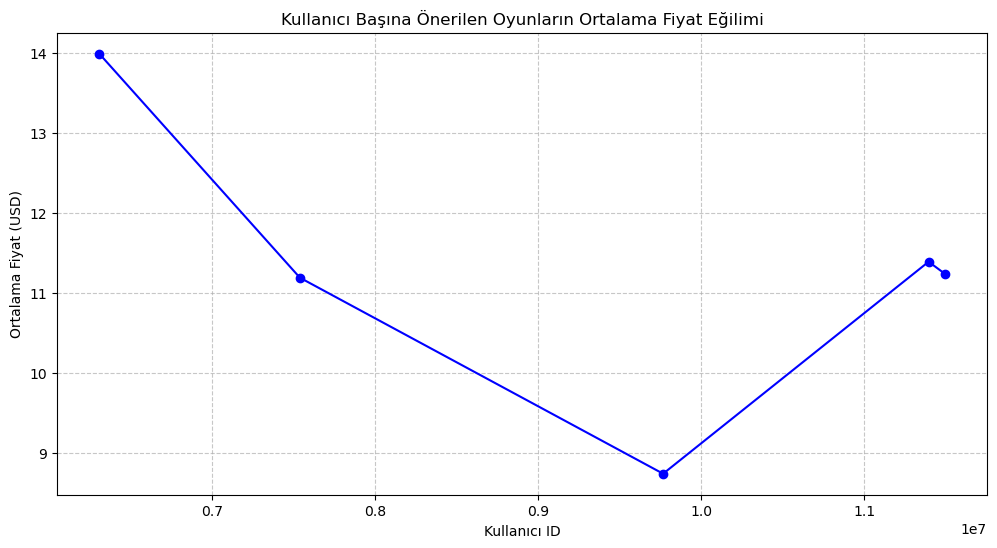

In [33]:
# Tüm önerilen oyunları birleştir
all_recommendations = pd.concat(user_recommendations.values())

# Kullanıcı başına ortalama fiyatı hesapla
avg_price_per_user = all_recommendations.groupby('user_id')['price_original'].mean()

# Çizgi grafiği
plt.figure(figsize=(12, 6))
plt.plot(avg_price_per_user.index, avg_price_per_user.values, marker='o', linestyle='-', color='blue')
plt.title('Kullanıcı Başına Önerilen Oyunların Ortalama Fiyat Eğilimi')
plt.xlabel('Kullanıcı ID')
plt.ylabel('Ortalama Fiyat (USD)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

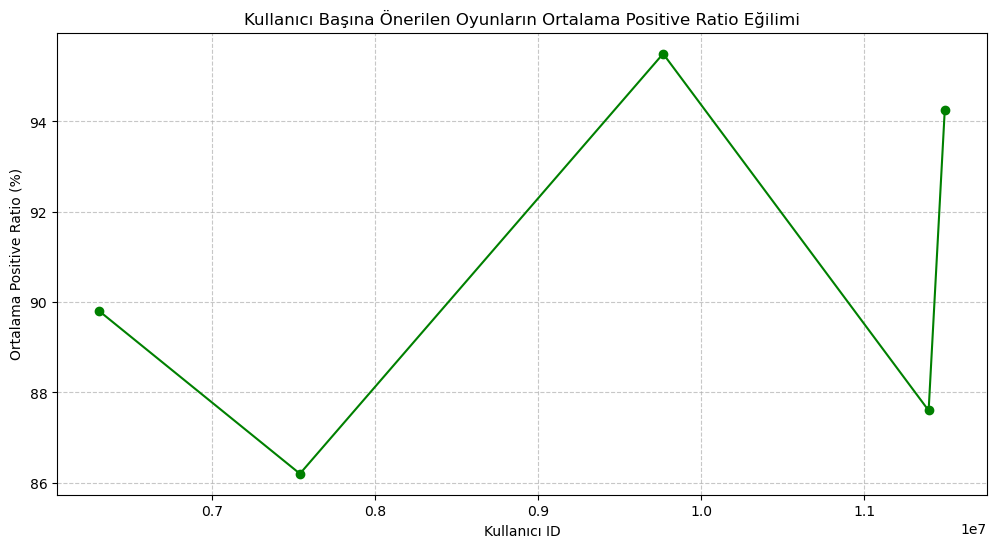

In [35]:
# Kullanıcı başına ortalama positive_ratio hesapla
avg_positive_ratio_per_user = all_recommendations.groupby('user_id')['positive_ratio'].mean()

# Çizgi grafiği
plt.figure(figsize=(12, 6))
plt.plot(avg_positive_ratio_per_user.index, avg_positive_ratio_per_user.values, marker='o', linestyle='-', color='green')
plt.title('Kullanıcı Başına Önerilen Oyunların Ortalama Positive Ratio Eğilimi')
plt.xlabel('Kullanıcı ID')
plt.ylabel('Ortalama Positive Ratio (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

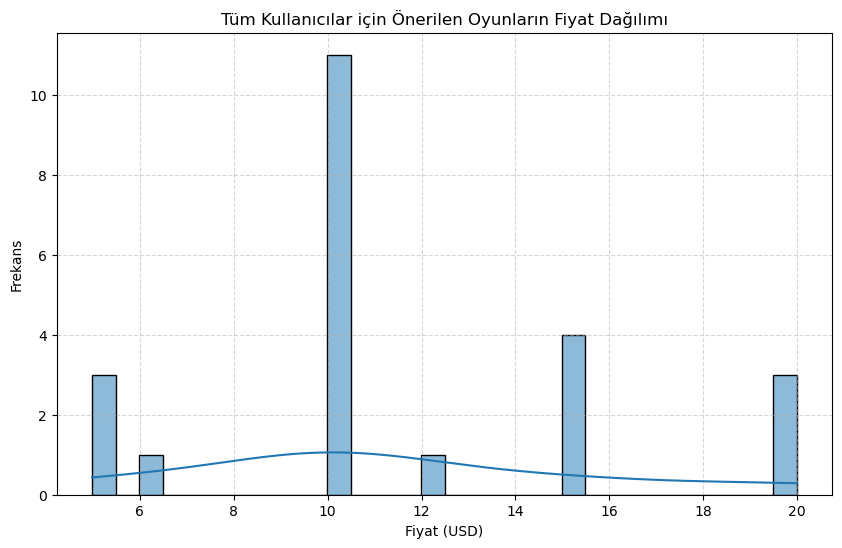

In [37]:
# Fiyat dağılımını görselleştir
plt.figure(figsize=(10, 6))
sns.histplot(all_recommendations['price_original'], bins=30, kde=True)
plt.title('Tüm Kullanıcılar için Önerilen Oyunların Fiyat Dağılımı')
plt.xlabel('Fiyat (USD)')
plt.ylabel('Frekans')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

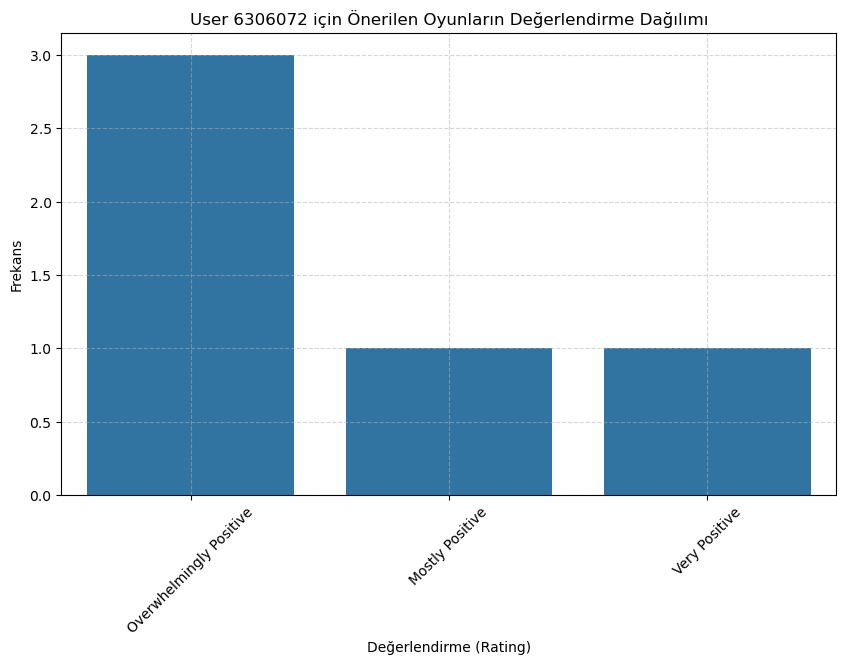

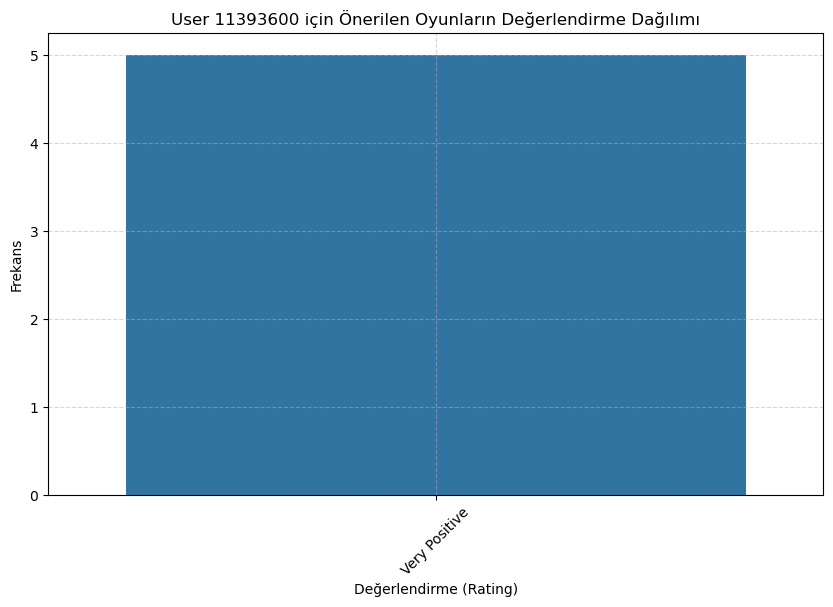

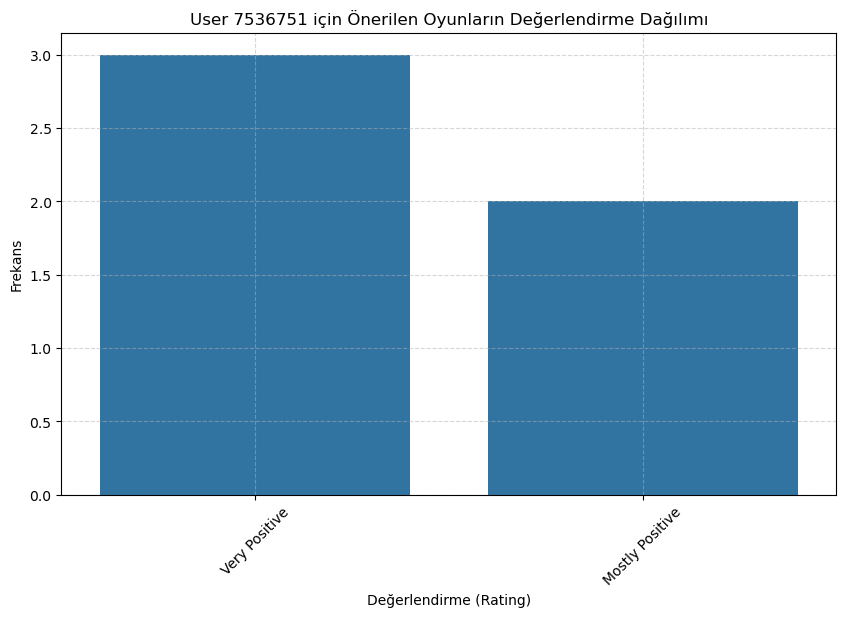

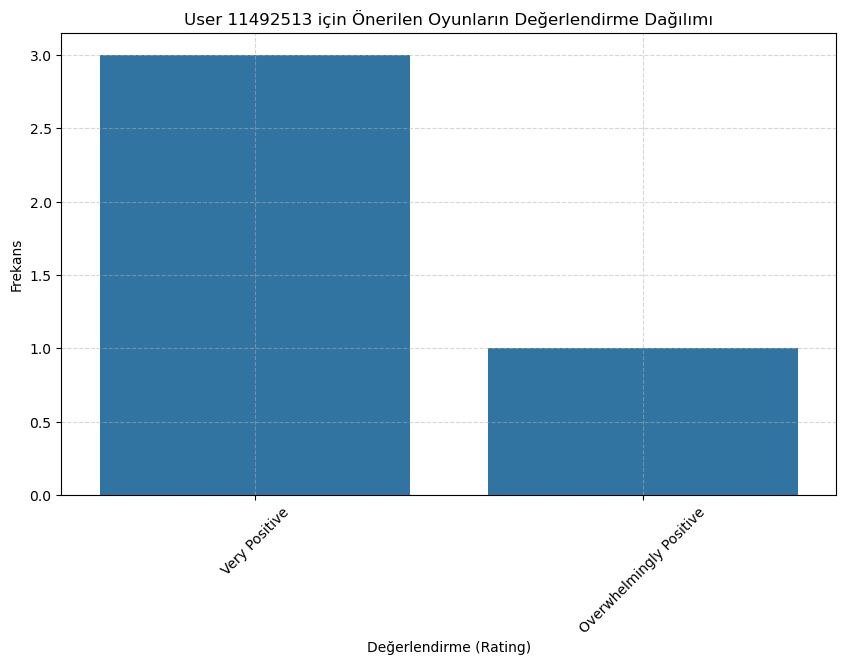

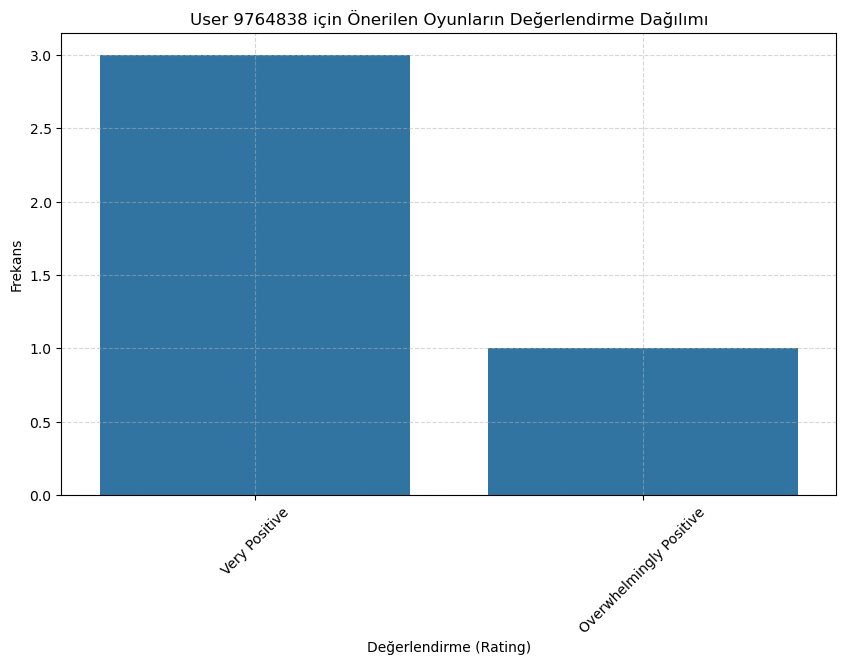

In [39]:
for user, recommendations in user_recommendations.items():
    plt.figure(figsize=(10, 6))
    sns.countplot(data=recommendations, x='rating', order=recommendations['rating'].value_counts().index)
    plt.title(f'User {user} için Önerilen Oyunların Değerlendirme Dağılımı')
    plt.xlabel('Değerlendirme (Rating)')
    plt.ylabel('Frekans')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

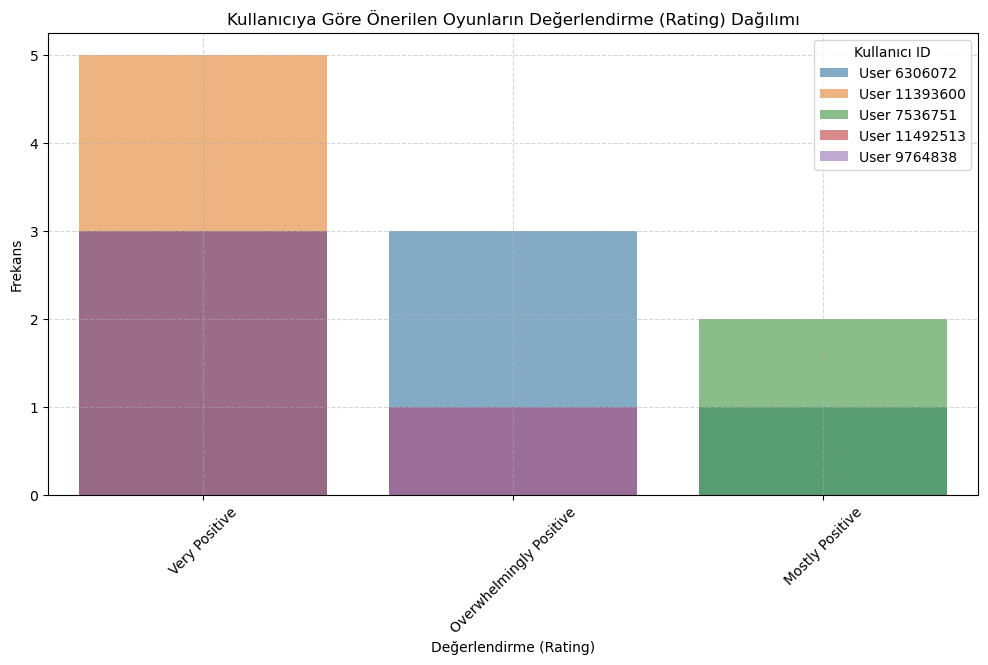

In [41]:
plt.figure(figsize=(12, 6))

# Her kullanıcı için ayrı rating dağılımı
for user, recommendations in user_recommendations.items():
    sns.countplot(data=recommendations, x='rating', order=all_recommendations['rating'].value_counts().index, label=f"User {user}", alpha=0.6)

plt.title('Kullanıcıya Göre Önerilen Oyunların Değerlendirme (Rating) Dağılımı')
plt.xlabel('Değerlendirme (Rating)')
plt.ylabel('Frekans')
plt.legend(title='Kullanıcı ID')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()